# Audio processing features

## Audio plot / cleaning

The `load_audio` supports a large variety of audio formats, as well as video formats. Check the `README` file for a better overview of the supported extensions ;)

The first 2 plots show the debugging of `trim_silence` (`debug = True`) : the vertical lines depict the trimming positions. The parts before / after are considered as *silence* (and removed). If you prefer to remove silences *within* the audio (and not only at its start / end), you should set the `method = 'remove'` value.

This trimming can be helpful for `Text-To-Speech (TTS)` model training.

**Note** : the `noisereduce` library has been updated with a `v2`. However, I have decided to use, by default, the old version behavior (`use_v1 = True`), as the new version is too agressive, making audios not smooth anymore (as shown in the plots `cleaned` and `cleaned_v2`). As the v1 is not maintained anymore, an updated version is integrated in `utils/audio/noisereducev1.py` in order to ensure compatibility with the new `librosa` version. Therefore, if you do not want to use the new behavior, you do not have to install the `noisereduce` library.

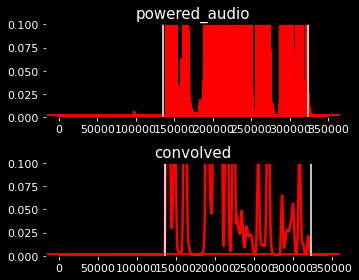

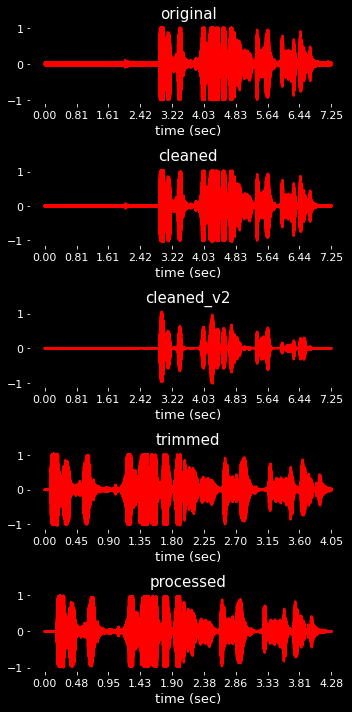

In [1]:
from utils import plot_multiple
from utils.audio import load_audio, read_audio, display_audio, trim_silence, reduce_noise

filename       = 'example_data/audio_test.wav'
rate, original = read_audio(filename)

noise_reduced    = reduce_noise(original, rate = rate)
noise_reduced_v2 = reduce_noise(original, rate = rate, use_v1 = False)

trimmed          = trim_silence(
    noise_reduced, method = 'window', debug = True, plot_kwargs = {'x_size' : 5, 'y_size' : 2, 'ncols' : 1}
)

processed = load_audio(filename, None, reduce_noise = True, trim_silence = True)

# `plot_type = 'audio'` uses a custom plot function that sets the `xtick_labels` to the audio's time (in sec) instead of raw values
# This require passing the `rate` positional argument
# Note that `plot_audio` also accepts multi-channels audios (audio with shapes [n_channels, n_samples])
plot_multiple(
    original = original, cleaned = noise_reduced, cleaned_v2 = noise_reduced_v2, trimmed = trimmed, processed = processed,
    rate = rate, use_subplots = True, ncols = 1, x_size = 5, y_size = 2, plot_type = 'audio'
)

## Play audio

The `display_audio` leverages the `IPython.display` module, allowing to display audio in Jupyter notebooks. In contrast, the `play_audio` leverages the `sounddevice` to play audio on the speakers

In [ ]:
_ = display_audio(original, rate = rate)
_ = display_audio(noise_reduced, rate = rate)
_ = display_audio(noise_reduced_v2, rate = rate)
_ = display_audio(trimmed, rate = rate)
_ = display_audio(processed, rate = 22050)

In [ ]:
from utils.audio import play_audio

play_audio(original, rate = rate)

## Mel Spectrogram

Note : the `ylabel` is set by default to *`Frequency (Hz)`* which is correct for a classical `STFT`, but not in the case of a `Mel Spectrogram (MFCC)`, which does not represent the raw frequencies, but a non-linear transformation of the `STFT`. 

The `load_mel` method internally calls `load_audio` (if it is not already a mel-spectrogram). It therefore accepts all the arguments accepted by `load_audio` (e.g. `reduce_noise`, `trim_silence`, etc.). 

The below cell demonstrates the `TacotronSTFT` computation. The `utils.audio.stft` defines multiple variants of the `MFCC` computation, specific to different models (e.g., `Whisper`, `DeepSpeech2`, ...). 

**Warning** : raw multi-channels audio have a shape `[n_channels, n_samples)`, which will be interpreted as a mel-spectrogram (as it is a 2-D array), so make sure to apply the function to each channel independantly. 

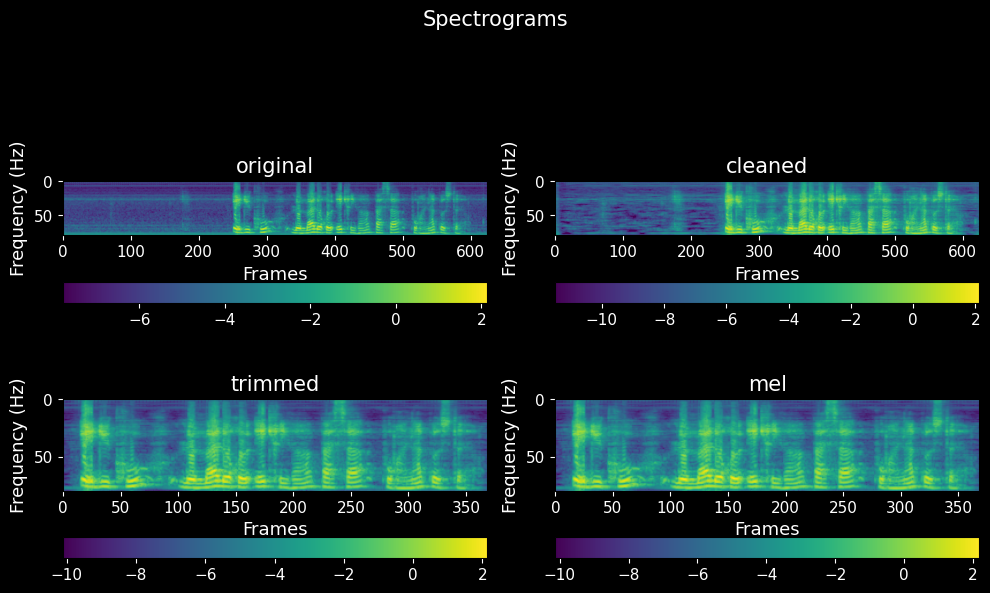

In [4]:
from utils import plot_spectrogram
from utils.audio import TacotronSTFT, load_audio, load_mel
from utils.audio import trim_silence, reduce_noise

stft = TacotronSTFT()

filename      = 'example_data/audio_test.wav'
audio         = load_audio(filename, stft.rate)
audio_nr      = reduce_noise(audio, rate = stft.rate)
audio_trimmed = trim_silence(audio_nr, rate = stft.rate, method = 'window')

original      = stft(audio)
noise_reduced = stft(audio_nr)
trimmed       = stft(audio_trimmed)

mel           = load_mel(filename, stft, reduce_noise = True, trim_silence = True)

plot_spectrogram(
    original = original, cleaned = noise_reduced, trimmed = trimmed, mel = mel,
    filename = 'example_data/plots/example_spectrogram.png', show = True, ncols = 2
)

In [5]:
stft_filename = 'example_data/stft_config.json'

stft.save_to_file(stft_filename)
restored = TacotronSTFT.load_from_file(stft_filename)

print(stft)
print(restored)


========== TacotronSTFT ==========
filter_length	: 1024
hop_length	: 256
win_length	: 1024
n_mel_channels	: 80
sampling_rate	: 22050
mel_fmin	: 0.0
mel_fmax	: 8000.0
normalize_mode	: None
pre_emph	: 0.0
window	: hann
to_magnitude	: True
periodic	: True


========== TacotronSTFT ==========
filter_length	: 1024
hop_length	: 256
win_length	: 1024
n_mel_channels	: 80
sampling_rate	: 22050
mel_fmin	: 0.0
mel_fmax	: 8000.0
normalize_mode	: None
pre_emph	: 0.0
window	: hann
to_magnitude	: True
periodic	: True

